# Comparing Random and Same sampling strategies in EpiOS

## Introduction

In this notebook, we compare the following two strategies in EpiOS:

- Random

    This strategy samples individuals by choosing a random subset of people for each time step.

- Same

    This strategy follows the same people over the course of the epidemic.

### Imports

In [1]:
!pip install plotnine


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import epios

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Collecting data from pyEpiabm
This notebook takes data from the gibraltar_example of pyEpiabm (see `README.md` in the current directory).

This simulation was run over 365 days with a total population of 33078. Additionally, this data has the
new waning immunity features, so we get waves of infections. See the SIR plot below.

## SIR Plot for Gibraltar
![SIR Plot](simulation_outputs/simulation_flow_SIR_plot.png)

We ran the above simulation with no interventions, and so the number of infected forms waves and does not appear to decrease
over time.

### Accessing the data

In [3]:
path = '.'
# This assumes the python venv is installed under epios folder
demo_data = pd.read_csv(f'{path}/simulation_outputs/demographics.csv')
time_data = pd.read_csv(f'{path}/simulation_outputs/inf_status_history.csv')

### Using `epios.PostProcess` to generate a single prediction

Given a specific `sample_strategy`, we can get a prediction using the `Base` method from `epios.PostProcess`.

In [4]:
def predict_base(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Base` method from `epios.PostProcess` to plot and predict
    incidence rate from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Base(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, prediction = result[0], np.array(result[1]) * pop_size
    true = diff + prediction

    return times, true, prediction

### Finding samples using both Random and Same strategies

In [5]:
def rand_and_same(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the Random and Same sampling strategies,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy and
        predictions with Same strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    base_random = predict_base(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, pred_random = base_random

    # Do prediction and comparison with Same sampling strategy - this tracks
    # the same people every time step
    pred_same = predict_base(post_process=post_process,
                             sample_size=sample_size,
                             time_sample=time_sample,
                             comparison=comparison,
                             sample_strategy='Same')[2]

    return times, true, pred_random, pred_same

## Sampling

Here, we take multiple samples using both strategies.

### Initialising the post process

In [6]:
post_process = epios.PostProcess(demo_data=demo_data, time_data=time_data)

# Initialise the random_predictions, same_predictions and RMSEs
random_predictions = []
same_predictions = []
random_rmses = []
same_rmses = []

### Running the Random and Same strategies multiple times
We run them for `num_iters` iterations so that we can average over the results. We also choose to take `sample_size=100` and 
`time_sample=[0, ..., 299]` to see the full effects of waning immunity.

In [7]:
num_iters = 50
sample_size = 30
for j in range(num_iters):
    predictions = rand_and_same(post_process=post_process,
                                sample_size=sample_size,
                                time_sample=list(range(300)),
                                comparison=True)
    times, true, pred_random, pred_same = predictions
    random_predictions.append(pred_random)
    same_predictions.append(pred_same)

    rmse_random = np.sqrt(((true - pred_random) ** 2).mean())
    rmse_same = np.sqrt(((true - pred_same) ** 2).mean())
    random_rmses.append(rmse_random)
    same_rmses.append(rmse_same)
    print(f"Iteration {j}")
    print(f"Root mean squared error for random sampling: {rmse_random}")
    print(f"Root mean squared error for same sampling: {rmse_same}")

Iteration 0
Root mean squared error for random sampling: 2404.1347556241517
Root mean squared error for same sampling: 2063.7772117810264
Iteration 1
Root mean squared error for random sampling: 2356.266181115085
Root mean squared error for same sampling: 2464.1702966042476
Iteration 2
Root mean squared error for random sampling: 2448.3799542554666
Root mean squared error for same sampling: 2657.316434952124
Iteration 3
Root mean squared error for random sampling: 2163.6422887344384
Root mean squared error for same sampling: 2512.3518448126115
Iteration 4
Root mean squared error for random sampling: 2374.6834407137303
Root mean squared error for same sampling: 2533.0983973518805
Iteration 5
Root mean squared error for random sampling: 2443.0540114100354
Root mean squared error for same sampling: 2732.841974355634
Iteration 6
Root mean squared error for random sampling: 2306.497135166947
Root mean squared error for same sampling: 2502.043986290675
Iteration 7
Root mean squared error for

In [8]:
# Get large arrays with all predictions
random_array = np.array(random_predictions)
same_array = np.array(same_predictions)

### Saving to .csv files

In [9]:
random_df = pd.DataFrame(random_array, columns=list(times))
same_df = pd.DataFrame(same_array, columns=list(times))
random_df.to_csv(f'sampling/random_strategy/predictions_ss_{sample_size}.csv')
same_df.to_csv(f'sampling/same_strategy/predictions_ss_{sample_size}.csv')

### Reading from .csv files

In [11]:
random_df = pd.read_csv(f'sampling/random_strategy/predictions_ss_{sample_size}.csv')
same_df = pd.read_csv(f'sampling/same_strategy/predictions_ss_{sample_size}.csv')
random_array = random_df.to_numpy()[:, 1:]
same_array = same_df.to_numpy()[:, 1:]
# Get the true result from time_data
true_result = []
for t in range(300):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result.append(num)
true = np.array(true_result)
print(true)

[  100    94   104   142   205   288   381   499   668   890  1181  1528
  2012  2609  3305  4216  5281  6427  7606  8812  9996 11182 12313 13274
 13893 14288 14501 14481 14231 13883 13335 12741 12134 11455 10879 10148
  9447  8810  8153  7575  7001  6545  6086  5664  5333  5033  4755  4530
  4310  4195  4083  3944  3833  3773  3689  3675  3692  3743  3859  3984
  4160  4266  4456  4632  4829  5039  5238  5451  5781  6036  6266  6513
  6716  6908  7100  7318  7472  7690  7918  8060  8220  8356  8423  8429
  8474  8456  8335  8316  8220  8116  8067  7969  7810  7683  7504  7356
  7228  7144  7021  6872  6779  6713  6601  6479  6400  6285  6185  6127
  6072  6016  5915  5900  5856  5833  5778  5816  5921  5995  6102  6169
  6242  6285  6352  6422  6532  6654  6679  6773  6810  6800  6883  6981
  7051  7068  7118  7116  7130  7151  7234  7263  7269  7241  7250  7243
  7276  7305  7297  7363  7403  7398  7373  7338  7297  7212  7136  7087
  7059  6982  6970  6930  6901  6964  6932  6887  6

In [12]:
random_rmses = []
same_rmses = []
num_iters = 50
for j in range(num_iters):
    pred_random = random_array[j, :]
    pred_same = same_array[j, :]
    rmse_random = np.sqrt(((true - pred_random) ** 2).mean())
    rmse_same = np.sqrt(((true - pred_same) ** 2).mean())
    random_rmses.append(rmse_random)
    same_rmses.append(rmse_same)

### Finding means and standard deviations

In [13]:

# Find their means and standard deviations
mean_random_array = np.mean(random_array, axis=0)
mean_same_array = np.mean(same_array, axis=0)
std_dev_random_array = np.std(random_array, axis=0)
std_dev_same_array = np.std(same_array, axis=0)

random_rmse_array = np.array(random_rmses)
same_rmse_array = np.array(same_rmses)
mean_random_rmse = np.sqrt(((true - mean_random_array) ** 2).mean())
mean_same_rmse = np.sqrt(((true - mean_same_array) ** 2).mean())
print(f"Root mean squared error for random sampling: {mean_random_rmse}")
print(f"Root mean squared error for panel sampling: {mean_same_rmse}")

Root mean squared error for random sampling: 326.01052608077947
Root mean squared error for panel sampling: 336.3179160871848


## Plotting

These plots mimic the ones produced in EpiOS, but here we are using the arrays averaged over a number
of iterations.

### Random strategy

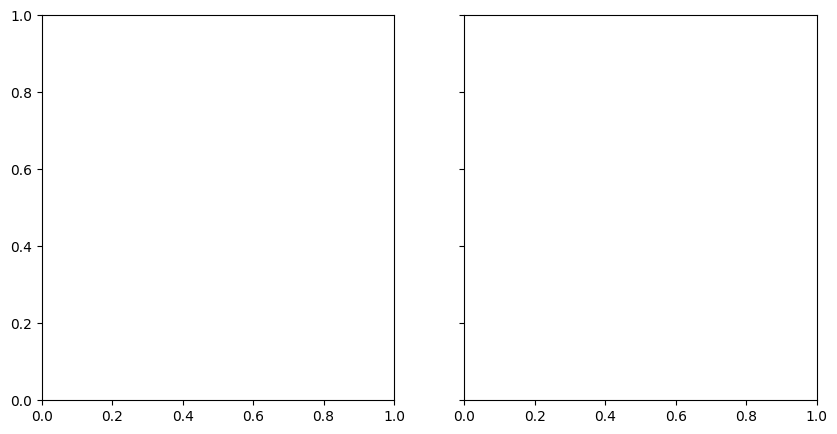

In [14]:
# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

In [15]:
legend = {"Predicted result": mean_random_array, "True result": true, 
          "Absolute difference": np.abs(mean_random_array - true)}
times = np.array(range(300))
for label in legend.keys():
    ax1.plot(times, legend[label], label=label)
ax1.set_xlabel("Time")
ax1.set_ylabel("Prevalence")
ax1.legend()
ax1.set_title("Random Sampling")
# ax1.savefig("sampling/random_strategy/comparison.png")

Text(0.5, 1.0, 'Random Sampling')

### Same strategy

In [16]:
legend = {"Predicted result": mean_same_array, "True result": true, 
          "Absolute difference": np.abs(mean_same_array - true)}

for label in legend.keys():
    ax2.plot(times, legend[label], label=label)
ax2.set_xlabel("Time")
ax2.set_ylabel("Prevalence")
ax2.legend()
ax2.set_title("Panel Sampling")
# ax2.savefig("sampling/random_strategy/comparison.png")
fig.suptitle("Predicted Prevalence Averaged over 50 Iterations")

Text(0.5, 0.98, 'Predicted Prevalence Averaged over 50 Iterations')

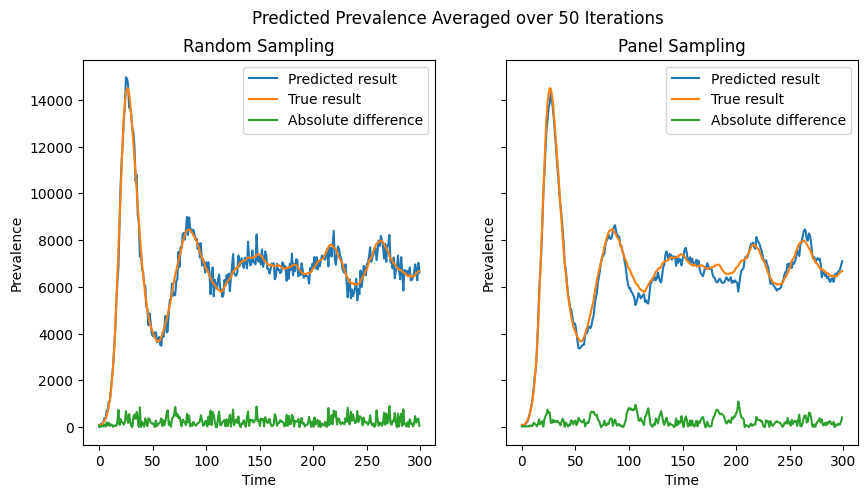

In [17]:
fig

In [18]:
fig.savefig(f"sampling/ss_{sample_size}/predictions.png")
fig.clf()

### Plotting RMSEs for the different strategies

Here we plot the root mean squared errors away from the true prevalence for Random vs Same sampling as 
two histograms, to provide a comparison.

In [19]:
rmse_df = pd.DataFrame(np.array([random_rmse_array, same_rmse_array]).transpose(), 
                       columns=['Random Sampling', 'Panel Sampling'])

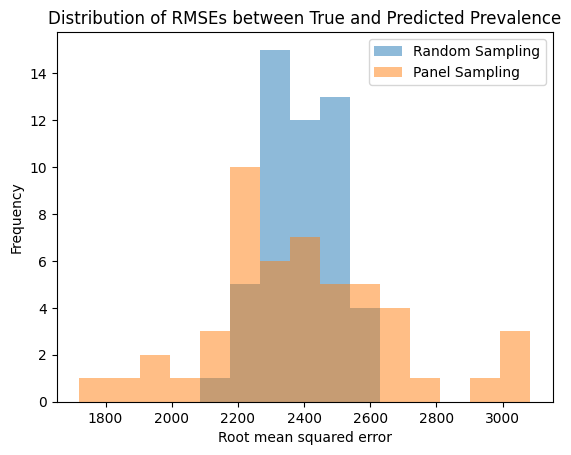

In [20]:
rmse_df.plot(kind='hist', title='Distribution of RMSEs between True and Predicted Prevalence',
             alpha=0.5, bins=15, xlabel='Root mean squared error')
plt.savefig(f"sampling/ss_{sample_size}/rmse_distribution.png")

In [21]:
random_rmse_mean = np.mean(random_rmse_array)
same_rmse_mean = np.mean(same_rmse_array)
random_rmse_std_dev = np.std(random_rmse_array)
same_rmse_std_dev = np.std(same_rmse_array)
print(f"Mean RMSE for Random sampling = {random_rmse_mean}, standard deviation for Random sampling = {random_rmse_std_dev}")
print(f"Mean RMSE for Same sampling = {same_rmse_mean}, standard deviation for Same sampling = {same_rmse_std_dev}")

Mean RMSE for Random sampling = 2393.1166107574263, standard deviation for Random sampling = 102.6957510686527
Mean RMSE for Same sampling = 2397.0313585057183, standard deviation for Same sampling = 282.59653021029254


### Creating a QQ Plot for Noise

We wish to use a quantile-quantile plot to see what the distribution of the RMSEs for the two different sampling strategies may be.
The above histograms suggest a potential normal distribution, so we will check this first using scipy.stats.probplot

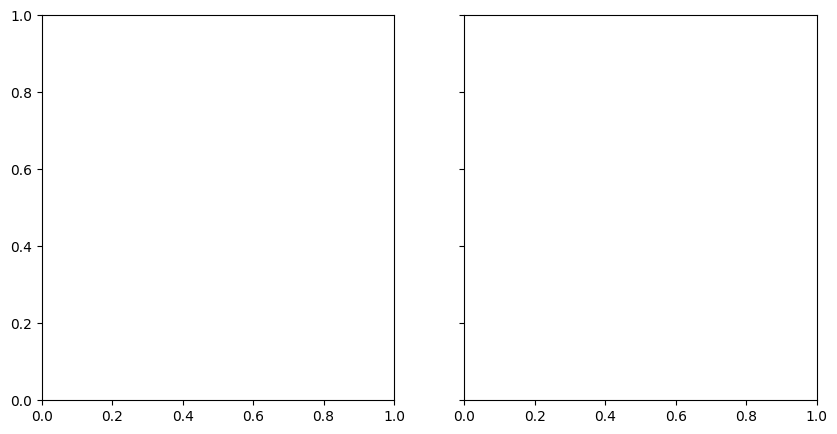

In [22]:
from scipy import stats
# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

In [23]:
stats.probplot(random_rmse_array, dist='norm', fit=True, plot=ax1, rvalue=True)
ax1.set_title("Random Strategy")
ax1.set_ylabel("Root mean squared error")
fig.suptitle("QQ Plot for a Normal Distribution for RMSEs")

Text(0.5, 0.98, 'QQ Plot for a Normal Distribution for RMSEs')

In [24]:
stats.probplot(same_rmse_array, dist='norm', fit=True, plot=ax2, rvalue=True)
ax2.set_ylabel("")
ax2.set_title("Panel Strategy")

Text(0.5, 1.0, 'Panel Strategy')

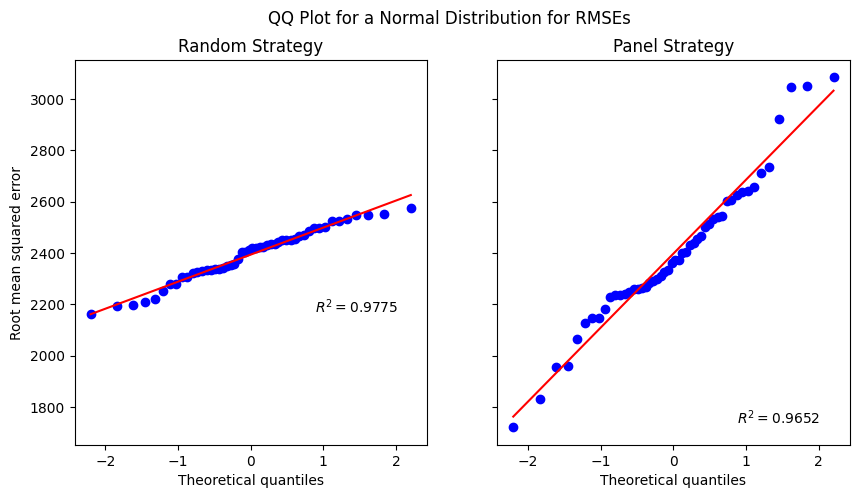

In [25]:
fig

In [26]:
fig.savefig(f"sampling/ss_{sample_size}/qqplot.png")
fig.clf()

### Plotting means and variances against true values

We would now like to plot the variances over all iterations (as a time series) against the true values, to see if we
find a linear relationship. A linear relationship would imply that a Poisson process dictates the errors

In [27]:
from plotnine import ggplot, aes, geom_smooth, geom_point, ggtitle, scale_y_continuous

In [28]:
variance_random_array = std_dev_random_array ** 2
variance_same_array = std_dev_same_array ** 2
variance_random_df = pd.DataFrame(np.array([true, variance_random_array]).transpose(), columns=["True prevalence", 
                                                                                                "Variance of predicted prevalences"])
variance_same_df = pd.DataFrame(np.array([true, variance_same_array]).transpose(), columns=["True prevalence", 
                                                                                            "Variance of predicted prevalences"])

variance_random_df["Sampling strategy"] = ["Random"] * 300
variance_same_df["Sampling strategy"] = ["Panel"] * 300
variance_df = pd.concat([variance_random_df, variance_same_df], axis=0)

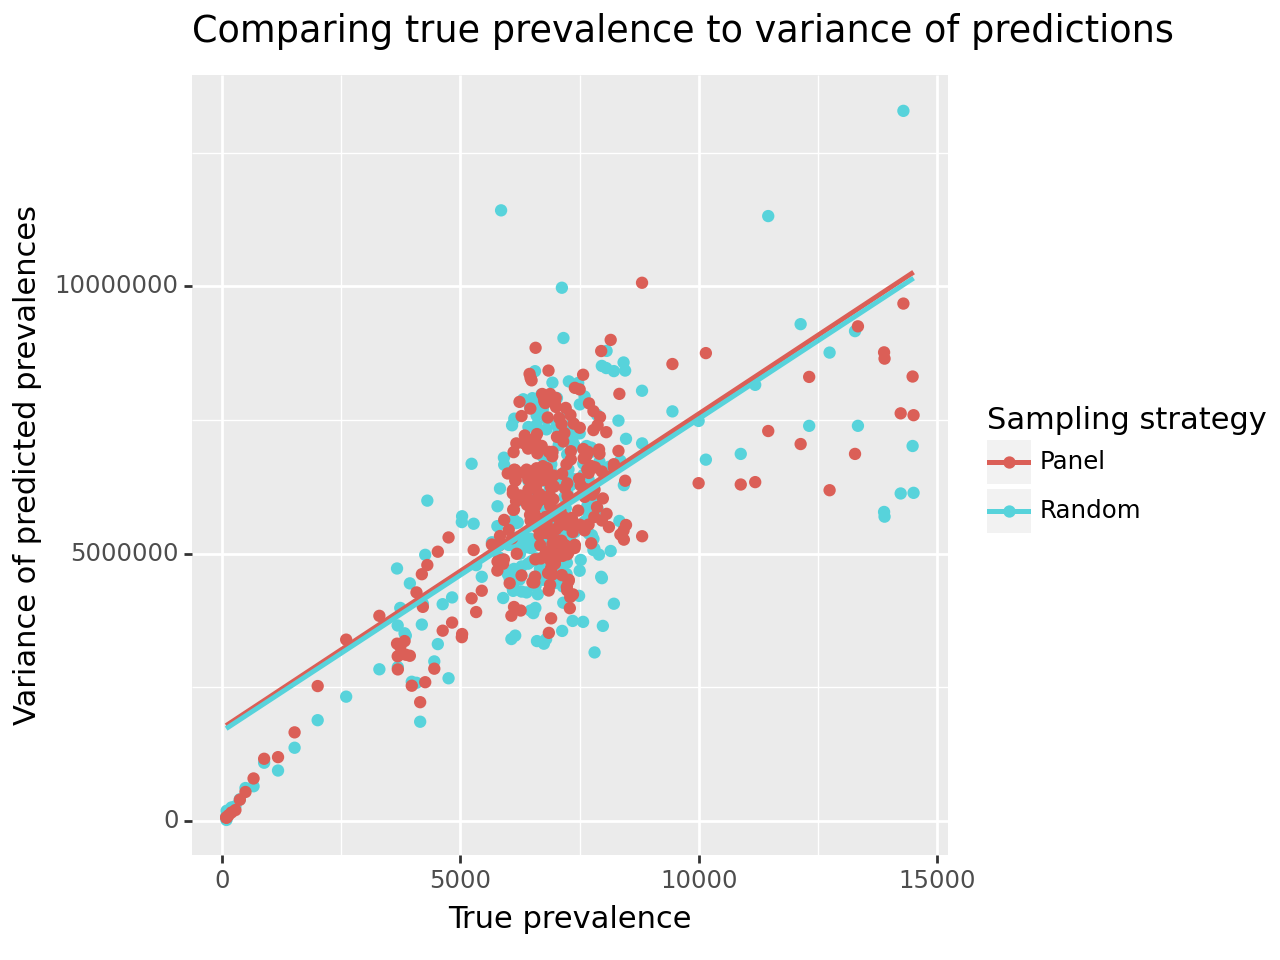


R^2 for Random strategy: 0.6767626969401568
R^2 for Panel strategy: 0.7338085306301199


In [29]:
plot1 = (ggplot(variance_df, aes(x='True prevalence', y='Variance of predicted prevalences', color='Sampling strategy'))
        + geom_point()
        + geom_smooth(method='lm', se=False)
        + scale_y_continuous()
        + ggtitle("Comparing true prevalence to variance of predictions")
       )
print(plot1)
# R^2 value
r_squared_random = stats.linregress(variance_random_df['True prevalence'], 
                                    variance_random_df['Variance of predicted prevalences'])[2]
r_squared_same = stats.linregress(variance_same_df['True prevalence'], 
                                  variance_same_df['Variance of predicted prevalences'])[2]
print(f"R^2 for Random strategy: {r_squared_random}")
print(f"R^2 for Panel strategy: {r_squared_same}")

In [33]:
plot1.save(f"sampling/ss_{sample_size}/variance_against_true.png")

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: sampling/ss_30/variance_against_true.png


In [31]:
mean_random_df = pd.DataFrame(np.array([true, mean_random_array]).transpose(), columns=["True prevalence", 
                                                                                        "Mean of predicted prevalences"])
mean_same_df = pd.DataFrame(np.array([true, mean_same_array]).transpose(), columns=["True prevalence", 
                                                                                    "Mean of predicted prevalences"])

mean_random_df["Sampling strategy"] = ["Random"] * 300
mean_same_df["Sampling strategy"] = ["Panel"] * 300
mean_df = pd.concat([mean_random_df, mean_same_df], axis=0)

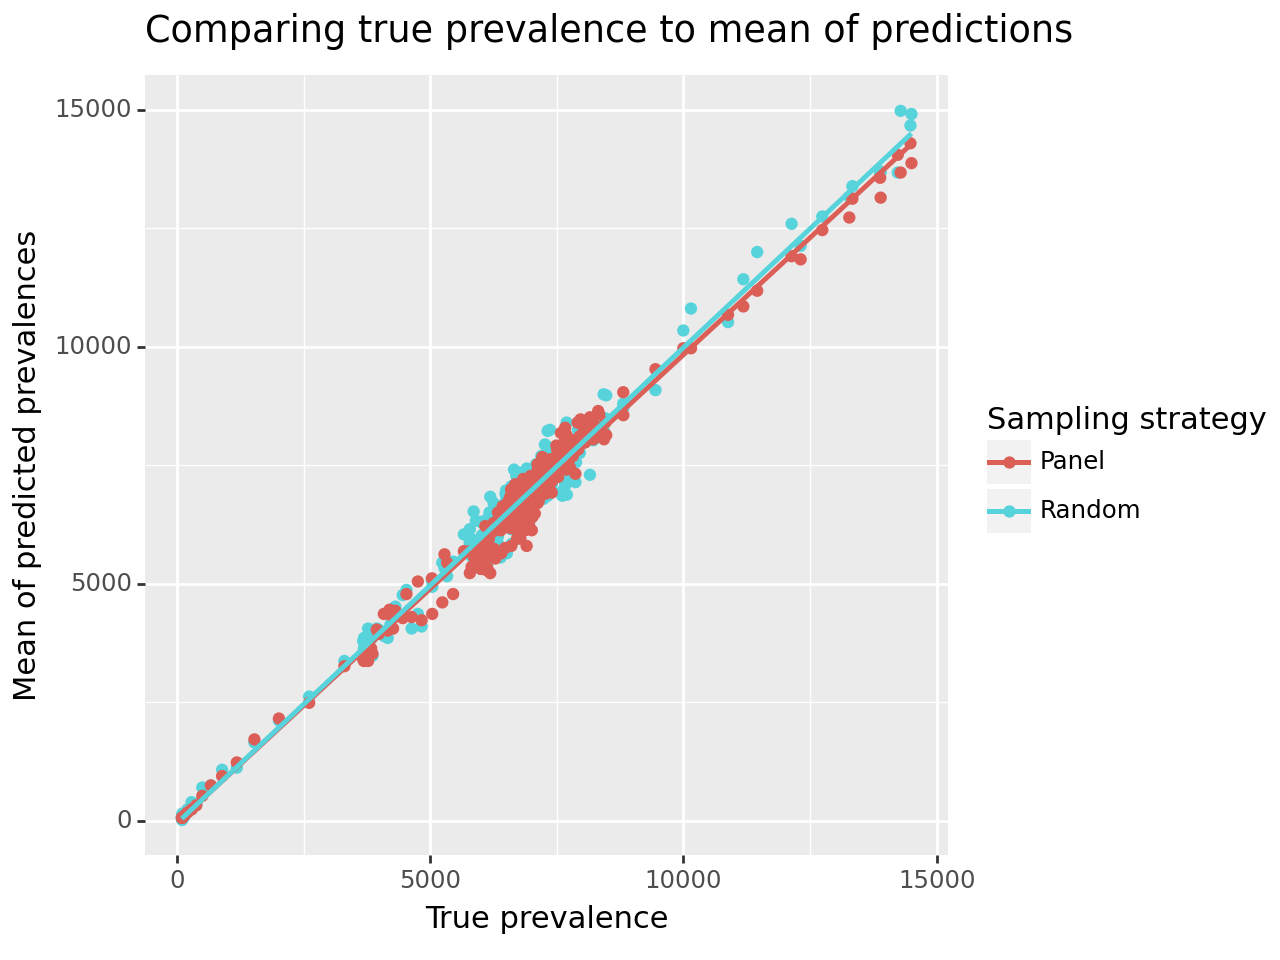


R^2 for Random strategy: 0.98882334366629
R^2 for Panel strategy: 0.9894025140668664


In [32]:
plot2 = (ggplot(mean_df, aes(x='True prevalence', y='Mean of predicted prevalences', color='Sampling strategy'))
        + geom_point()
        + geom_smooth(method='lm', se=False)
        + scale_y_continuous()
        + ggtitle("Comparing true prevalence to mean of predictions")
       )
print(plot2)
# R^2 value
r_squared_random = stats.linregress(mean_random_df['True prevalence'], 
                                    mean_random_df['Mean of predicted prevalences'])[2]
r_squared_same = stats.linregress(mean_same_df['True prevalence'], 
                                  mean_same_df['Mean of predicted prevalences'])[2]
print(f"R^2 for Random strategy: {r_squared_random}")
print(f"R^2 for Panel strategy: {r_squared_same}")

In [34]:
plot2.save(f"sampling/ss_{sample_size}/mean_against_true.png")

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: sampling/ss_30/mean_against_true.png


In [35]:
!pip install patchworklib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


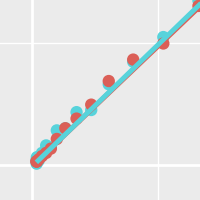

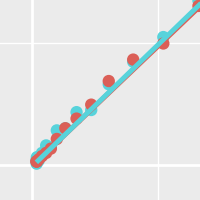

In [36]:
import patchworklib as pw
plot_variance = pw.load_ggplot(plot1, figsize=(4, 4))
plot_mean = pw.load_ggplot(plot2, figsize=(4, 4))
plot_mean_and_variance = plot_mean | plot_variance
plot_mean_and_variance.savefig(f"sampling/ss_{sample_size}/mean_and_variance.png")

In [37]:
import math

In [38]:
likelihood_ratio_random = 0
for i in range(300):
    inner_sum = 0
    for j in range(50):
        inner_sum += random_array[j][i]
    likelihood_ratio_random += (inner_sum * (math.log(true[i]) - math.log(inner_sum/50) + 1) - 50 * true[i])

print(-2 * likelihood_ratio_random)

247048.73728202857


In [39]:
likelihood_ratio_same = 0
for i in range(300):
    inner_sum = 0
    for j in range(50):
        inner_sum += same_array[j][i]
    likelihood_ratio_same += (inner_sum * (math.log(true[i]) - math.log(inner_sum/50) + 1) - 50 * true[i])

print(-2 * likelihood_ratio_same)

262188.11889200524


## Analysis

We see that both strategies perform reasonably well when averaging over the `num_iters`. However, the Random sampling
strategy appears to be noisier, particularly at later times when the natural immunity of the population begins to wane and
the second wave of infections begins. We do not see this effect using the Same sampling strategy to the same extent.

This implies that following the same people over a simulation may improve the quality of the sampling. Furthermore, this may
lead to better results later in the simulation, where the same individuals get re-sampled after catching the disease a second
or third time.

The RMSE histograms show an interesting pattern, with a very narrow distribution for the Random strategy but a much wider
distribution for the Same strategy. One potential reason for this would be that certain people represent the population as
a whole a lot better. In particular, if we track people who are reinfected multiple times then this will more likely reflect
the true population.